### Filtering for only *vaseyana* diploids

Uses ARTR_chr.biallelic.vcf.gz to start

Sample names have been extracted to subset using:   
- zcat ARTR_chr.vcf.gz | bcftools query -l | sort > sample_index.txt

In [1]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [2]:
vcfutils = "vcfutils.pl"
vcftools = "vcftools"
bcftools = "bcftools"
bgzip = "bgzip"
tabix = "tabix"
java = "java"
plink = "plink --noweb"

In [3]:
analysis_dir = "/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering"

In [4]:
cd $analysis_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering


In [5]:
vcf_file = os.path.join(analysis_dir, "ARTR_chr.biallelic.recode.vcf.gz")
assert os.path.exists(vcf_file)
vcf_file

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/ARTR_chr.biallelic.recode.vcf.gz'

### keep only AV2 individuals

In [6]:
sample_names = pd.read_csv('sample_index.txt',header=None,names=['sample'])
sample_names.head()

,sample
0,AT2_BB_1
1,AT2_BB_10
2,AT2_BB_11
3,AT2_BB_12
4,AT2_BB_13


In [7]:
AV2_indv = [s for s in sample_names['sample'] if 'AV2' in s]

In [10]:
len(AV2_indv), AV2_indv[0]

(172, 'AV2_AN_1')

In [11]:
with open(os.path.join(analysis_dir, "AV2_indv.txt"), "w") as o:
    o.write("INDV\n")
    for elem in AV2_indv:
        o.write("%s\n" % elem)

In [12]:
!$vcftools --gzvcf $vcf_file \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--keep {os.path.join(analysis_dir, "AV2_indv.txt")} \
--out {os.path.join(analysis_dir, "AV2_chr.biallelic")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/ARTR_chr.biallelic.recode.vcf.gz
	--keep /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/AV2_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/AV2_chr.biallelic
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 172 out of 708 Individuals
Outputting VCF file...
After filtering, kept 2766918 out of a possible 2766918 Sites
Run Time = 1423.00 seconds


In [14]:
vcf_AV2 = "AV2_chr.biallelic.recode.vcf" 
vcf_AV2_gz = "%s.gz" % vcf_AV2
!$bgzip -c $vcf_AV2 > {vcf_AV2_gz}
!$tabix {vcf_AV2_gz}

## Remove by MAF, missing, and thin next

In [15]:
!$vcftools \
--max-missing 0.7 \
--maf 0.01 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_AV2_gz \
--out $'AV2_chr_miss70_thin100_MAF1'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf AV2_chr.biallelic.recode.vcf.gz
	--recode-INFO-all
	--maf 0.01
	--thin 100
	--max-missing 0.7
	--out AV2_chr_miss70_thin100_MAF1
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 172 out of 172 Individuals
Outputting VCF file...
After filtering, kept 458910 out of a possible 2766918 Sites
Run Time = 221.00 seconds


In [16]:
vcf_filtered = "AV2_chr_miss70_thin100_MAF1.recode.vcf"
vcf_filtered_gz = "%s.gz" % vcf_filtered

In [ ]:
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Remove bad_indv

by do it by mean_depth cause no missing data 

In [77]:
!$vcftools --gzvcf {vcf_filtered_gz} \
--out {vcf_filtered_gz} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf AV2_chr_miss70_thin100_MAF1.recode.vcf.gz
	--depth
	--out AV2_chr_miss70_thin100_MAF1.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 172 out of 172 Individuals
Outputting Mean Depth by Individual
After filtering, kept 458910 out of a possible 458910 Sites
Run Time = 13.00 seconds


In [78]:
depth_file = vcf_filtered_gz + ".idepth"
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,AV2_AN_1,458910,0.223035
1,AV2_AN_2,458910,0.182960
2,AV2_AN_3,458910,0.160840
3,AV2_AN_4,458910,0.171249
4,AV2_AN_5,458910,0.146397


In [79]:
depth_df.MEAN_DEPTH.describe()

count    172.000000
mean       0.188777
std        0.054205
min        0.000521
25%        0.151296
50%        0.187078
75%        0.213640
max        0.347393
Name: MEAN_DEPTH, dtype: float64

In [80]:
len(depth_df),len(depth_df[depth_df.MEAN_DEPTH <= .05]),len(depth_df[depth_df.MEAN_DEPTH <= .1]), len(depth_df[depth_df.MEAN_DEPTH <= .15])


(172, 2, 4, 41)

In [81]:
bad_indv = depth_df.INDV[depth_df.MEAN_DEPTH <= .1]

In [82]:
with open(os.path.join(analysis_dir, "bad_indv.txt"), "w") as o:
    o.write("INDV\n")
    for elem in bad_indv:
        o.write("%s\n" % elem)

In [83]:
!cat bad_indv.txt

INDV
AV2_NV_1
AV2_PL_10
AV2_SN_128
AV2_TF_149


In [84]:
!$vcftools --gzvcf $vcf_filtered_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--remove {os.path.join(analysis_dir, "bad_indv.txt")} \
--out {os.path.join(analysis_dir, "snps_indv_removed")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf AV2_chr_miss70_thin100_MAF1.recode.vcf.gz
	--remove /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/bad_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/snps_indv_removed
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
Excluding individuals in 'exclude' list
After filtering, kept 168 out of 172 Individuals
Outputting VCF file...
After filtering, kept 458910 out of a possible 458910 Sites
Run Time = 151.00 seconds


In [85]:
vcf_bad_remove = os.path.join(analysis_dir, "snps_indv_removed.recode.vcf")
vcf_bad_remove_gz = vcf_bad_remove + ".gz"
!$bgzip -c {vcf_bad_remove} > {vcf_bad_remove_gz}
!$tabix {vcf_bad_remove_gz}

# Filter snps further 
this needs to be done after removing individuals


In [86]:
def get_vcf_stats(vcf_gz):
    
    stats = ['depth',
            'site-depth',
            'site-mean-depth',
            'site-quality',
            'missing-site',
            'freq',
            'counts',
            'hardy',
            'het']
    
    for stat in stats:
        !$vcftools --gzvcf $vcf_gz \
        --out $vcf_gz \
        {"--%s" % stat} 

In [87]:
get_vcf_stats(vcf_bad_remove_gz)


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/snps_indv_removed.recode.vcf.gz
	--depth
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 168 out of 168 Individuals
Outputting Mean Depth by Individual
After filtering, kept 458910 out of a possible 458910 Sites
Run Time = 12.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/snps_indv_removed.recode.vcf.gz
	--site-depth

Using zlib version: 1.2.11
After filtering, kept 168 out of 168 Individuals
Outputting Depth for Each Site
After filtering, kept 458910 out of a possible 458910 Sites
Run Time = 15.00 seco

After filtering, kept 458910 out of a possible 458910 Sites
Run Time = 12.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/snps_indv_removed.recode.vcf.gz
	--hardy
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 168 out of 168 Individuals
Outputting HWE statistics (but only for biallelic loci)
After filtering, kept 458910 out of a possible 458910 Sites
Run Time = 18.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/snps_indv_removed.recode.vcf.gz
	--het
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 168 out of 168 Individuals
Outputting Ind

In [88]:
#pd.set_option('display.max_columns', 100)

def get_MAF(row):
    try:
        return np.min([row.A1_freq, row.A2_freq])
    except:
        print(row)
        
def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def calculate_Fis(vals):
    try:
        data = [float(x) for x in vals.split("/")]
        assert len(data) == 3
        num_individuals = np.sum(data)
        total_alleles = 2*num_individuals
        a1_count = 2*data[0]
        a2_count = 2*data[2]
        het_count = data[1]
        a1_count += het_count
        a2_count += het_count
        a1_freq = a1_count/total_alleles
        a2_freq = a2_count/total_alleles
        assert a1_freq + a2_freq == 1.0
        He = 2 * a1_freq * a2_freq * get_correction(num_individuals)
        Ho = het_count/num_individuals
        Fis = 1 - (Ho/He)
        return Fis
    except:
        return -9

def combine_vcf_stats(filedir, prefix):
    
    hardy_files = !ls {filedir}/{prefix}.hwe
    hardy = pd.read_csv(hardy_files[0], sep="\t")

    hardy.columns = ['CHROM', 'POS', 'OBS(HOM1/HET/HOM2)', 'E(HOM1/HET/HOM2)', 'ChiSq_HWE',
       'P_HWE', 'P_HET_DEFICIT', 'P_HET_EXCESS']
    hardy.index = hardy.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_files = !ls {filedir}/{prefix}.l* | grep -v log
    loci_df = pd.concat([pd.read_csv(x, sep="\t", skiprows=0) for x in loci_files], axis=1)
    chrom_pos = loci_df.ix[:,0:2]
    
    frq_files = !ls {filedir}/{prefix}.frq* | grep -v count
    frq_data = []
    h = open(frq_files[0])
    header = h.readline().strip().split()
    for line in h:
        frq_data.append(line.strip().split('\t'))

    header = ['CHROM', 'POS', 'N_ALLELES', 'N_CHR', 'A1_FREQ', "A2_FREQ"]
    frq_df = pd.DataFrame(frq_data)
    print(frq_df.columns)
    #frq_df = frq_df.drop([6,7],axis=1)
    frq_df.columns = header
    frq_df.index = frq_df.apply(lambda x: "%s-%s" % (x.CHROM, x.POS), axis=1)
    
    loci_df = loci_df.drop(['CHROM','CHR','POS'], axis=1)
    loci_df = pd.concat([chrom_pos, loci_df], axis=1)
    loci_df.index = loci_df.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_df = pd.concat([loci_df, frq_df, hardy], axis=1)
    loci_df["A1_allele"] = loci_df.apply(lambda row: row.A1_FREQ.split(":")[0], axis=1)
    loci_df["A2_allele"] = loci_df.apply(lambda row: row.A2_FREQ.split(":")[0], axis=1)
    
    loci_df["A1_freq"] = loci_df.apply(lambda row: float(row.A1_FREQ.split(":")[1]), axis=1)
    loci_df["A2_freq"] = loci_df.apply(lambda row: float(row.A2_FREQ.split(":")[1]), axis=1)
    
    loci_df['MAF'] = loci_df.apply(get_MAF, axis=1)
    loci_df = loci_df.drop(['CHROM', 'POS'], axis=1)
    
    loci_df['Fis'] = loci_df['OBS(HOM1/HET/HOM2)'].apply(calculate_Fis)
    
    return loci_df, frq_df, hardy

In [89]:
vcf_bad_remove_gz

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/snps_indv_removed.recode.vcf.gz'

In [90]:
loci_df, frq_df, hardy = combine_vcf_stats(analysis_dir,'snps_indv_removed.recode.vcf.gz')

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


RangeIndex(start=0, stop=6, step=1)


In [91]:
loci_df

,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,QUAL,N_ALLELES,...,ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS,A1_allele,A2_allele,A1_freq,A2_freq,MAF,Fis
CM042338.1-22493,0,0,0.000000,0.000000,336,0,0,0,7.82756,2,...,168.000000,6.522585e-50,1.000000,6.144880e-50,C,G,0.500000,0.500000,0.500000,-0.994048
CM042338.1-59140,82,152,0.488095,0.670516,336,0,0,0,999.00000,2,...,0.024387,1.000000e+00,1.000000,9.821164e-01,C,T,0.988095,0.011905,0.011905,-0.009036
CM042338.1-97078,0,0,0.000000,0.000000,336,0,0,0,35.79330,2,...,168.000000,6.522585e-50,1.000000,6.144880e-50,T,G,0.500000,0.500000,0.500000,-0.994048
CM042338.1-106063,0,0,0.000000,0.000000,336,0,0,0,999.00000,2,...,168.000000,6.522585e-50,1.000000,6.144880e-50,T,C,0.500000,0.500000,0.500000,-0.994048
CM042338.1-126072,93,207,0.553571,0.931245,336,0,0,0,999.00000,2,...,3.990804,1.554908e-01,0.155491,9.914965e-01,C,G,0.967262,0.032738,0.032738,0.156643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CM042346.1-338263844,0,0,0.000000,0.000000,336,0,0,0,35.79330,2,...,168.000000,6.522585e-50,1.000000,6.144880e-50,T,C,0.500000,0.500000,0.500000,-0.994048
CM042346.1-338268601,3,9,0.017857,0.053571,336,0,0,0,54.99990,2,...,164.047200,5.830745e-48,1.000000,5.192424e-48,A,G,0.497024,0.502976,0.497024,-0.982249
CM042346.1-338274068,0,0,0.000000,0.000000,336,0,0,0,7.82756,2,...,168.000000,6.522585e-50,1.000000,6.144880e-50,G,T,0.500000,0.500000,0.500000,-0.994048
CM042346.1-338287589,1,1,0.005952,0.005952,336,0,0,0,5.49146,2,...,168.000000,6.522585e-50,1.000000,6.144880e-50,G,A,0.500000,0.500000,0.500000,-0.994048


In [92]:
frq_df

,CHROM,POS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ
CM042338.1-22493,CM042338.1,22493,2,336,C:0.5,G:0.5
CM042338.1-59140,CM042338.1,59140,2,336,C:0.988095,T:0.0119048
CM042338.1-97078,CM042338.1,97078,2,336,T:0.5,G:0.5
CM042338.1-106063,CM042338.1,106063,2,336,T:0.5,C:0.5
CM042338.1-126072,CM042338.1,126072,2,336,C:0.967262,G:0.0327381
...,...,...,...,...,...,...
CM042346.1-338263844,CM042346.1,338263844,2,336,T:0.5,C:0.5
CM042346.1-338268601,CM042346.1,338268601,2,336,A:0.497024,G:0.502976
CM042346.1-338274068,CM042346.1,338274068,2,336,G:0.5,T:0.5
CM042346.1-338287589,CM042346.1,338287589,2,336,G:0.5,A:0.5


In [93]:
hardy

,CHROM,POS,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS
CM042338.1-22493,CM042338.1,22493,0/168/0,42.00/84.00/42.00,168.000000,6.522585e-50,1.000000,6.144880e-50
CM042338.1-59140,CM042338.1,59140,164/4/0,164.02/3.95/0.02,0.024387,1.000000e+00,1.000000,9.821164e-01
CM042338.1-97078,CM042338.1,97078,0/168/0,42.00/84.00/42.00,168.000000,6.522585e-50,1.000000,6.144880e-50
CM042338.1-106063,CM042338.1,106063,0/168/0,42.00/84.00/42.00,168.000000,6.522585e-50,1.000000,6.144880e-50
CM042338.1-126072,CM042338.1,126072,158/9/1,157.18/10.64/0.18,3.990804,1.554908e-01,0.155491,9.914965e-01
...,...,...,...,...,...,...,...,...
CM042346.1-338263844,CM042346.1,338263844,0/168/0,42.00/84.00/42.00,168.000000,6.522585e-50,1.000000,6.144880e-50
CM042346.1-338268601,CM042346.1,338268601,0/167/1,41.50/84.00/42.50,164.047200,5.830745e-48,1.000000,5.192424e-48
CM042346.1-338274068,CM042346.1,338274068,0/168/0,42.00/84.00/42.00,168.000000,6.522585e-50,1.000000,6.144880e-50
CM042346.1-338287589,CM042346.1,338287589,0/168/0,42.00/84.00/42.00,168.000000,6.522585e-50,1.000000,6.144880e-50


In [94]:
loci_out = os.path.join(analysis_dir,'loci_out.csv')
frq_out = os.path.join(analysis_dir,'frq_out.csv')
hardy_out = os.path.join(analysis_dir,'hardy_out.csv')

loci_df.to_csv(path_or_buf=loci_out)
frq_df.to_csv(path_or_buf=frq_out)
hardy.to_csv(path_or_buf=hardy_out)


In [95]:
loci_df.SUM_DEPTH.describe()

count    458910.000000
mean         32.259761
std         147.568200
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max       39722.000000
Name: SUM_DEPTH, dtype: float64

In [96]:
loci_df.MEAN_DEPTH.describe()

count    458910.000000
mean          0.192022
std           0.878382
min           0.000000
25%           0.000000
50%           0.000000
75%           0.011905
max         236.440000
Name: MEAN_DEPTH, dtype: float64

In [97]:
loci_df.QUAL.describe()

count    458910.000000
mean        246.315496
std         410.036646
min           3.114000
25%           7.827560
50%          16.130650
75%         110.108000
max         999.000000
Name: QUAL, dtype: float64

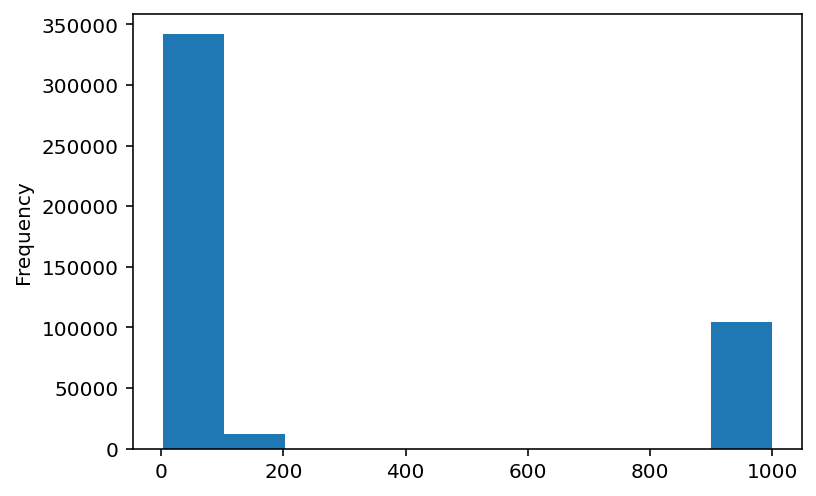

In [98]:
loci_df.QUAL.plot(kind="hist");

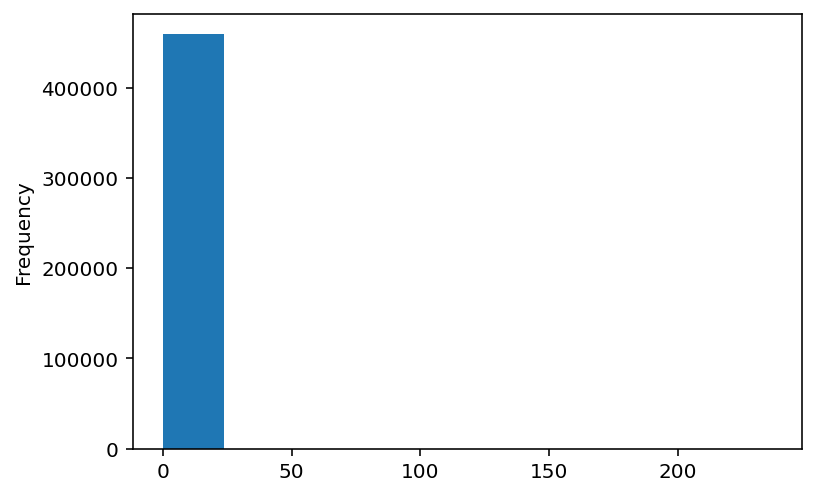

In [99]:
loci_df.MEAN_DEPTH.plot(kind="hist");

In [100]:
len(loci_df[loci_df.Fis == -9])

0

In [101]:
len(loci_df[loci_df.SUM_DEPTH <5000]),len(loci_df[loci_df.SUM_DEPTH >=200])

(458899, 25102)

In [102]:
len(loci_df[loci_df.MEAN_DEPTH > 25 ]),len(loci_df[loci_df.MEAN_DEPTH >= 1])

(12, 30446)

In [103]:
len(loci_df[loci_df.QUAL >= 20]) - len(loci_df[loci_df.QUAL >= 30])

14907

In [104]:
len(loci_df[loci_df.QUAL >  20]), len(loci_df[loci_df.QUAL > 50]), len(loci_df[loci_df.QUAL > 100])

(227564, 157444, 118028)

In [105]:
 len(loci_df[loci_df.Fis <= -0.5]), len(loci_df[loci_df.MAF < 0.01])

(380758, 477)

In [106]:
def filter_snps(df, imputed=False):
    if imputed:
        return df[(df.MAF >= 0.01) &  
                  (df.Fis > -0.5)]
    else:
        return df[(df.MEAN_DEPTH >= 1) & 
                  (df.MEAN_DEPTH < 30) & 
                  (df.QUAL >= 100) & 
                  (df.MAF >= 0.01) &
                  (df.Fis >= -0.5)]

In [107]:
loci_stage1 = filter_snps(loci_df)
loci_stage1.shape

(27718, 25)

In [108]:
with open(os.path.join(analysis_dir, "stage1_positions.txt"), "w") as o:
    for elem in loci_stage1.index:
        o.write("%s\n" % "\t".join(elem.split("-")))

In [109]:
!$vcftools --gzvcf $vcf_bad_remove_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "stage1_positions.txt")} \
--out {os.path.join(analysis_dir, "good_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/snps_indv_removed.recode.vcf.gz
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/good_snps
	--positions /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/stage1_positions.txt
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 168 out of 168 Individuals
Outputting VCF file...
After filtering, kept 27718 out of a possible 458910 Sites
Run Time = 13.00 seconds


In [110]:
snps = os.path.join(analysis_dir, "good_snps.recode.vcf")
snps_gz = snps + ".gz"
!$bgzip -c {snps} > {snps_gz}
!$tabix {snps_gz}

# Make 012

In [111]:
f = os.path.join(analysis_dir, "good_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--012


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/good_snps.recode.vcf
	--012
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/good_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 168 out of 168 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 27718 out of a possible 27718 Sites
Run Time = 2.00 seconds


# Get coverage per individual

In [112]:
f = os.path.join(analysis_dir, "good_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/good_snps.recode.vcf
	--depth
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/good_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 168 out of 168 Individuals
Outputting Mean Depth by Individual
After filtering, kept 27718 out of a possible 27718 Sites
Run Time = 1.00 seconds


In [113]:
depth_file = os.path.join(analysis_dir, "good_snps.recode.vcf.idepth")
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,AV2_AN_1,27718,2.36828
1,AV2_AN_2,27718,1.93715
2,AV2_AN_3,27718,1.65726
3,AV2_AN_4,27718,1.80017
4,AV2_AN_5,27718,1.51447


In [114]:
depth_df.MEAN_DEPTH.describe()

count    168.000000
mean       2.073714
std        0.557698
min        1.061870
25%        1.633272
50%        2.033590
75%        2.301735
max        3.819790
Name: MEAN_DEPTH, dtype: float64

# Remove unnecessary files

In [115]:
!rm snps*

In [116]:
!rm *vcf